# [6.4. Multiple Input and Multiple Output Channels](https://d2l.ai/chapter_convolutional-neural-networks/channels.html)


<img src='./images/conv_operation.png' width='800'/>

&emsp; <sub>  * Image Credit : https://www.kaggle.com/manmohan291/57-cnn-basics

In this example, the input array/image has 3 channels. We want the output to have 2 channels. <br> 
With a convolution kernel of size **3 x 3**, **how many parameters does this convolutional layer has ?** <br>
- **weight** parameters : **input_channels x output_channels x 3 x 3**
- **bias** parameters : **output_channels**
    
Why multiple output channels?
- So that we can capture multiple aspects of an image at each spatial location. <br> E.g. The 1st filter can learn to detect horizontal edge, and maybe the 2nd filter is learned to detect 45$^\circ$ edge.

In [1]:
# Let's count the number of parameters in a Conv2D layer in PyTorch

import torch
import torch.nn as nn

conv2d = nn.Conv2d(in_channels=3, out_channels=2, kernel_size=(3, 3), bias=True)

print('Weight parameter dimension : ', conv2d.weight.data.shape)
print('Bias parameter dimension : '  , conv2d.bias.data.shape)

Weight parameter dimension :  torch.Size([2, 3, 3, 3])
Bias parameter dimension :  torch.Size([2])


## 1 x 1 Convolutional Layer

<img src='./images/fig_6.4.2.png' width='800'/>

- Not like a typical convolutional layer, a 1×1 filter doesn't have a spatial extent to correlate adjacent pixels of the inputs. 


- The  1×1 convolutional layer is equivalent to the fully-connected layer, when applied on a per spatial pixel basis. Therefore, we can view it this way : the 1x1 convolution allows the model to **summarize the input feature maps** at each spatial location; the coefficients used in the weighted sum operation is stored in each of the 1x1 filter. 


- The **1x1 convolution** can be used to adjust the number of channels to control model model complexity. (Similar to **pooling** being used to reduce the width and height of an image.) 


# [6.5 Pooling](https://d2l.ai/chapter_convolutional-neural-networks/pooling.html)

# [6.6. Convolutional Neural Networks (LeNet)](https://d2l.ai/chapter_convolutional-neural-networks/lenet.html)

- **LeNet** was one of the earliest convolutional neural networks proposed by Yann LeCun at 1989 to identify handwritten digits. <br>
  Paper : [Backpropagation Applied to Handwritten Zip Code Recognition -- LeCun et al. 1989](https://ieeexplore.ieee.org/document/6795724)
  
  
- LeNet Architecture : <br>
  ConV -> Pool -> ConV -> Pool -> FC -> FC -> FC (-> Softmax)

<img src='./images/slide_LeNet.png' width='860'/>

- The basic units in **each convolutional block** are a **convolutional layer**, a **sigmoid activation function**, and a subsequent **average pooling** operation.


- **Flatten** the feature maps before passing into to the **fully connected layer**.


- In a CNN, convolutional layers are typically arranged so that they **gradually decrease the spatial resolution** of the representations, while **increasing the number of channels**.


- Total network parameters ~ 62k. Most of the parameters are belong to the fully connected layers. 


- The activation functions used back in 1990s is **sigmoid**, while modern CNNs uses **ReLU** in most of the time. Also **max-pooling** is a more common choice in modern CNNs, instead of the **avg-pooling** used here.

In [2]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt
plt.rc('font', size=16)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Define LeNet-5 in PyTorch

In [3]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

net.to(device)

# count total network parameters
print('Total network parameters :', sum(param.numel() for param in net.parameters() if param.requires_grad))

Total network parameters : 61706


## Train LeNet-5 on fashionMNIST

### Data : prepare dataset and dataloader

In [4]:
fmnist_train = datasets.FashionMNIST(
    root="../../../data", train=True, transform=transforms.ToTensor(), download=True)
fmnist_test = datasets.FashionMNIST(
    root="../../../data", train=False, transform=transforms.ToTensor(), download=True)

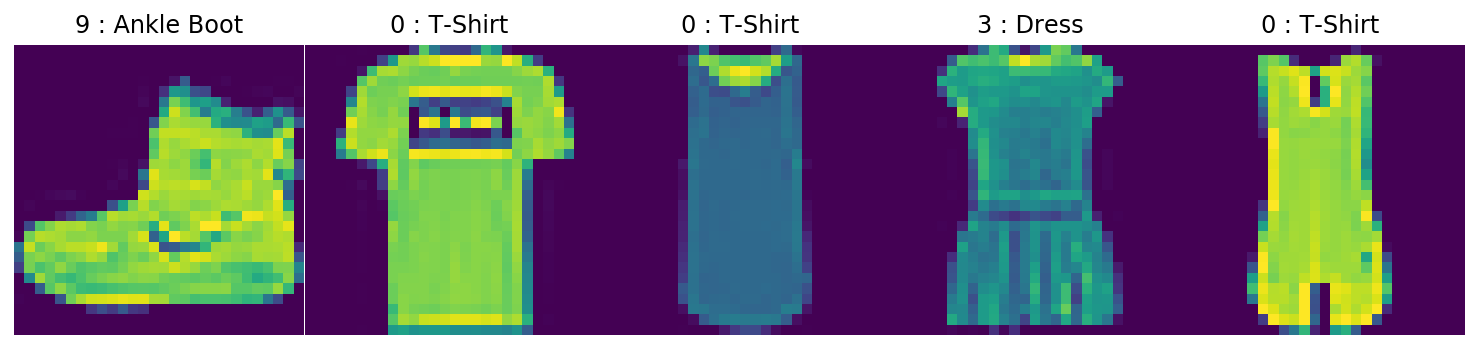

In [5]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

fig, axes = plt.subplots(1, 5, figsize=(13, 4))
plt.subplots_adjust(hspace=0.001, wspace=0.001)

for i in range(5):
    image, label = fmnist_train.__getitem__(i)
    axes[i].imshow(image.squeeze().numpy())
    axes[i].set_title(f'{label} : {labels_map[label]}')
    axes[i].axis('off')

In [6]:
batch_size = 100

train_loader = DataLoader(fmnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(fmnist_test, batch_size=batch_size, shuffle=True)

### Loss function

**Careful!** <br>
`nn.CrossEntropyLoss` applies: ``nn.LogSoftmax`` and ``nn.NLLLoss`` (negative log likelihood loss). <br>
So don't apply softmax in the forward loop. <br>
``Y`` is class (digit) labels, not one-hot!   <br>
``Y_pred`` has raw scores (logits), no Softmax!

In [7]:
criterion = nn.CrossEntropyLoss()

### Optimization Function

In [8]:
learning_rate = 0.5

optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

### Training Loop

In [9]:
def train_1_epoch(model, optimizer, train_loss, train_acc):
    
    model.train()             # set model to training mode

    running_loss = 0.
    running_corrects = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device) 
        labels = labels.to(device)
        
        # forward
        outputs = model(images)
        
        # loss
        loss = criterion(outputs, labels) # predicted outputs v.s. actual labels
        
        # backwards
        optimizer.zero_grad()  # zero gradient
        loss.backward()        # loss.backward would calculate dloss/dw_i  
        optimizer.step()       # update network parameters (w_i)
        
        # compute statistics (avg. loss, accuracy)
        running_loss += loss.item() * labels.size(0)
        _, predictions = torch.max(outputs, 1)
        running_corrects += torch.sum(predictions == labels.data)
        
        #if (i+1)%300 == 0: # every 300 steps, print something
        #    print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{len(train_loader)}, loss={loss.item():.4f}')
            
    epoch_loss = running_loss / len(fmnist_train)            ; train_loss.append(epoch_loss)
    epoch_acc  = running_corrects / len(fmnist_train) * 100. ; train_acc.append(epoch_acc)
    print(f'>>> End epoch {epoch+1}, train accuracy = {epoch_acc:.2f}%, train avgLoss = {epoch_loss:.4f}')

    
    
def validation(model, valid_loss, valid_acc):
    
    model.eval()              # set model to evaluation mode
    
    running_loss = 0.
    running_corrects = 0
    
    for i, (images, labels) in enumerate(test_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        # compute statistics (avg. loss, accuracy)
        running_loss += loss.item() * labels.size(0)
        _, predictions = torch.max(outputs, 1)
        running_corrects += torch.sum(predictions == labels.data)
    
    valid_loss.append(running_loss/len(test_loader.dataset))
    valid_acc.append(running_corrects/len(test_loader.dataset) * 100.)
    print(f'>>>              valid accuracy = {valid_acc[-1]:.2f}%, valid avgLoss = {valid_loss[-1]:.4f}')

In [10]:
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

num_epochs = 10
for epoch in range(0, num_epochs):
    train_1_epoch(net, optimizer, train_loss, train_acc)
    validation(net, valid_loss, valid_acc)

>>> End epoch 1, train accuracy = 9.97%, train avgLoss = 2.3130
>>>              valid accuracy = 10.00%, valid avgLoss = 2.3045
>>> End epoch 2, train accuracy = 9.90%, train avgLoss = 2.3050
>>>              valid accuracy = 10.00%, valid avgLoss = 2.3033
>>> End epoch 3, train accuracy = 9.69%, train avgLoss = 2.3044
>>>              valid accuracy = 10.00%, valid avgLoss = 2.3033
>>> End epoch 4, train accuracy = 9.94%, train avgLoss = 2.3042
>>>              valid accuracy = 10.00%, valid avgLoss = 2.3037
>>> End epoch 5, train accuracy = 10.00%, train avgLoss = 2.3039
>>>              valid accuracy = 10.00%, valid avgLoss = 2.3041
>>> End epoch 6, train accuracy = 9.94%, train avgLoss = 2.3034
>>>              valid accuracy = 18.44%, valid avgLoss = 2.3013
>>> End epoch 7, train accuracy = 19.06%, train avgLoss = 2.1068
>>>              valid accuracy = 39.91%, valid avgLoss = 1.4307
>>> End epoch 8, train accuracy = 54.41%, train avgLoss = 1.1147
>>>              valid accurac

### Plots

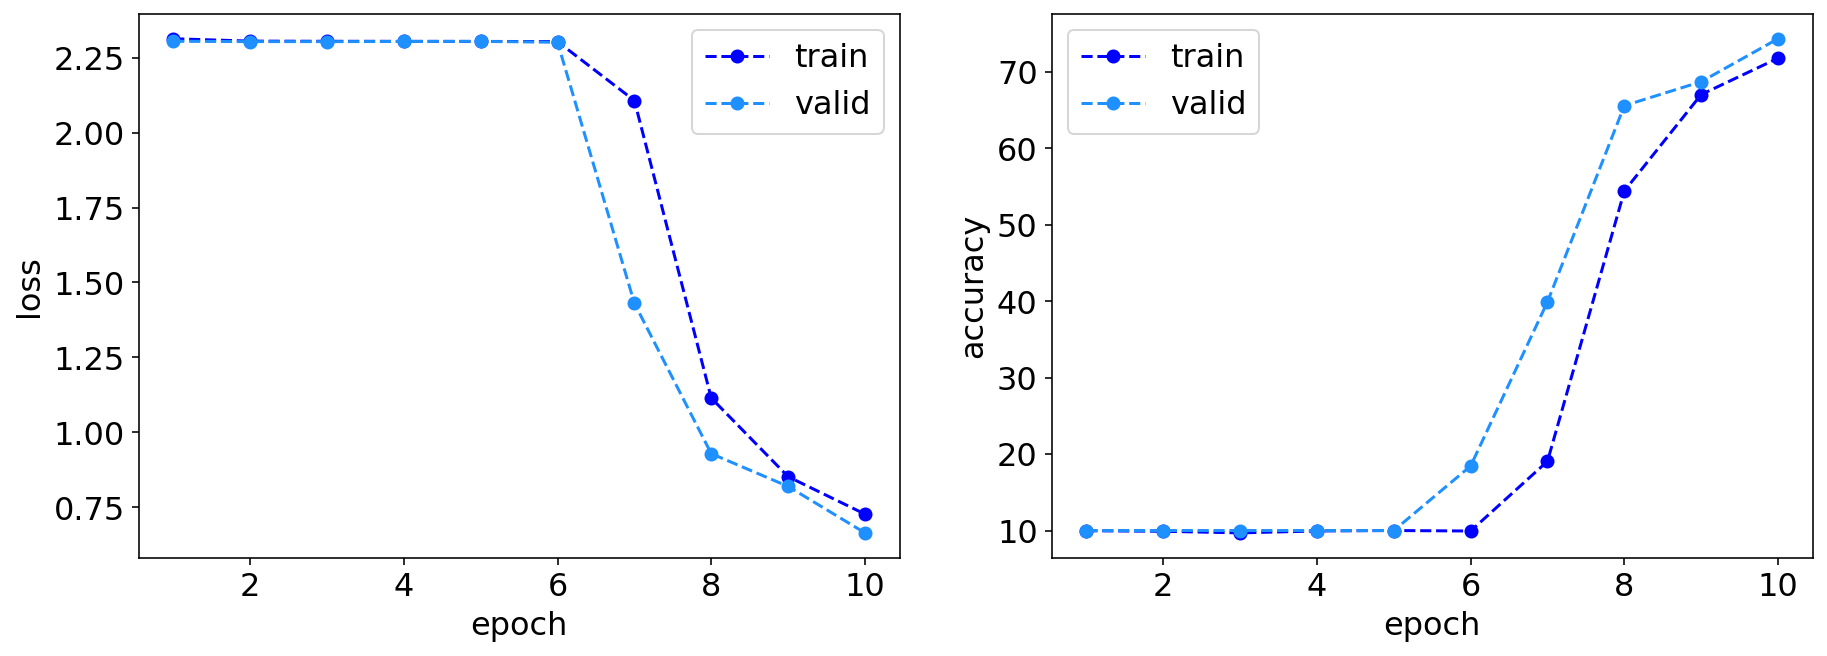

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plt.rc('font', size=16)

ax[0].plot(range(1,num_epochs+1)[::], train_loss[::], 'o--', label='train', color='b')
ax[0].plot(range(1,num_epochs+1)[::], valid_loss[::], 'o--', label='valid', color='dodgerblue')
ax[1].plot(range(1,num_epochs+1)[::], train_acc[::] , 'o--', label='train', color='b')
ax[1].plot(range(1,num_epochs+1)[::], valid_acc[::], 'o--', label='valid', color='dodgerblue')

ax[0].set_ylabel('loss')
ax[1].set_ylabel('accuracy')

for i in range(2):
    ax[i].set_xlabel('epoch')
    ax[i].legend(loc='best')